<a href="https://colab.research.google.com/github/alistasava/G1401221046/blob/main/Alista_Sava_Davina_G1401221046_Klasifikasi_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TUGAS 2 PRAK: TPM by ALISTA SAVA DAVINA - G1401221046**

# **KLASIFIKASI ANN**

## **INISIALISASI LIBRARY**

In [7]:
!pip install pandas
!pip install keras
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sn

## **INPUT DATA**

In [8]:
file_path = "/content/drive/MyDrive/Pakistan House Price.csv"
data = pd.read_csv(file_path, delimiter=";")
data = data.drop(columns=["property_id","location_id","page_url","date_added","location","latitude","longitude","area","date_added","agency","agent","Area Category"])
display(data)

,property_type,price,city,province_name,baths,purpose,bedrooms,Area Type,Area Size
0,Flat,10000000,Islamabad,Islamabad Capital,2,For Sale,2,Marla,4.0
1,Flat,6900000,Islamabad,Islamabad Capital,3,For Sale,3,Marla,5.6
2,House,16500000,Islamabad,Islamabad Capital,6,For Sale,5,Marla,8.0
3,House,43500000,Islamabad,Islamabad Capital,4,For Sale,4,Kanal,2.0
4,House,7000000,Islamabad,Islamabad Capital,3,For Sale,3,Marla,8.0
...,...,...,...,...,...,...,...,...,...
168441,House,26500000,Karachi,Sindh,0,For Sale,6,Marla,9.6
168442,House,12500000,Karachi,Sindh,0,For Sale,3,Marla,8.0
168443,House,27000000,Karachi,Sindh,0,For Sale,6,Marla,9.6
168444,House,11000000,Karachi,Sindh,0,For Sale,3,Marla,7.8


Analisis ini melakukan penghapusan beberapa peubah yang sekiranya irrelevan jika dimasukkan untuk proses tahapan analisis. Peubah-peubah yang direduksi diantaranya, 'propertuy_id', 'location_id', 'page_url', 'date_added', 'location', 'latitude', 'longitude','area', 'agency', 'ageny', dan 'Area Category'

### **PENYIAPAN DATA**

In [9]:
# Membuat variabel biner 'Harga'
data['Harga'] = data['price'].apply(lambda x: "Rendah" if x <= 17765760 else "Tinggi")

# Menghapus kolom 'price' dari dataset
data = data.drop(columns=['price'])

# Mengonversi 'Harga' menjadi tipe kategori (factor di R)
data['Harga'] = data['Harga'].astype('category')

# Mengecek tipe data dari 'Harga'
print(data['Harga'].dtype)

category


Pada tahap ini, data target atau peubah target 'Price' akan dikonversi menjadi sebuah bentuk biner dua kelas yaitu Rendah dan Tinggi yang dikelompokkan berdasarkan nilai rata-rata yang dimilikinya sebesar 17765760. Nilai pada 'Price' yang lebih kecil atau setara dengan nilai rata-ratanya akan dikonversi menjadi Rendah. Sedangkan, sisanya yang berada di atas nilai rata-ratanya akan dikonversi menjadi Tinggi. Hasil konversi ini disimpan ke dalam peubah baru yaitu 'Harga' sebagai data factor 2 level dengan type data category

## **EKSPLORASI**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168446 entries, 0 to 168445
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   property_type  168446 non-null  object  
 1   city           168446 non-null  object  
 2   province_name  168446 non-null  object  
 3   baths          168446 non-null  int64   
 4   purpose        168446 non-null  object  
 5   bedrooms       168446 non-null  int64   
 6   Area Type      168446 non-null  object  
 7   Area Size      168446 non-null  float64 
 8   Harga          168446 non-null  category
dtypes: category(1), float64(1), int64(2), object(5)
memory usage: 10.4+ MB


Berdasarkan eksplorasindeskriptif di atas, data yang digunakan berupa 5 peubah kategorik, 3 peubah numerik, dengan 1 peubah target perubah faktor 2 level. Data terdiri atas 168446 amatan dengan total peubah sebanyak 9

In [11]:
data.describe()

,baths,bedrooms,Area Size
count,168446.000000,168446.000000,168446.000000
mean,2.874227,3.179422,5.892188
std,2.463400,1.971401,5.778327
min,0.000000,0.000000,0.000000
25%,0.000000,2.000000,3.000000
50%,3.000000,3.000000,5.000000
75%,4.000000,4.000000,8.000000
max,403.000000,68.000000,800.000000


In [12]:
data.isnull().sum()

,0
property_type,0
city,0
province_name,0
baths,0
purpose,0
bedrooms,0
Area Type,0
Area Size,0
Harga,0


Tidak terdapat *missing value* di setiap kolom peubah ditunjukkan dengan nilai 0 pada peubah-peubah yang digunakan setelah dilakukan pengecakan *missing value*

**Histogram Data Numerik**

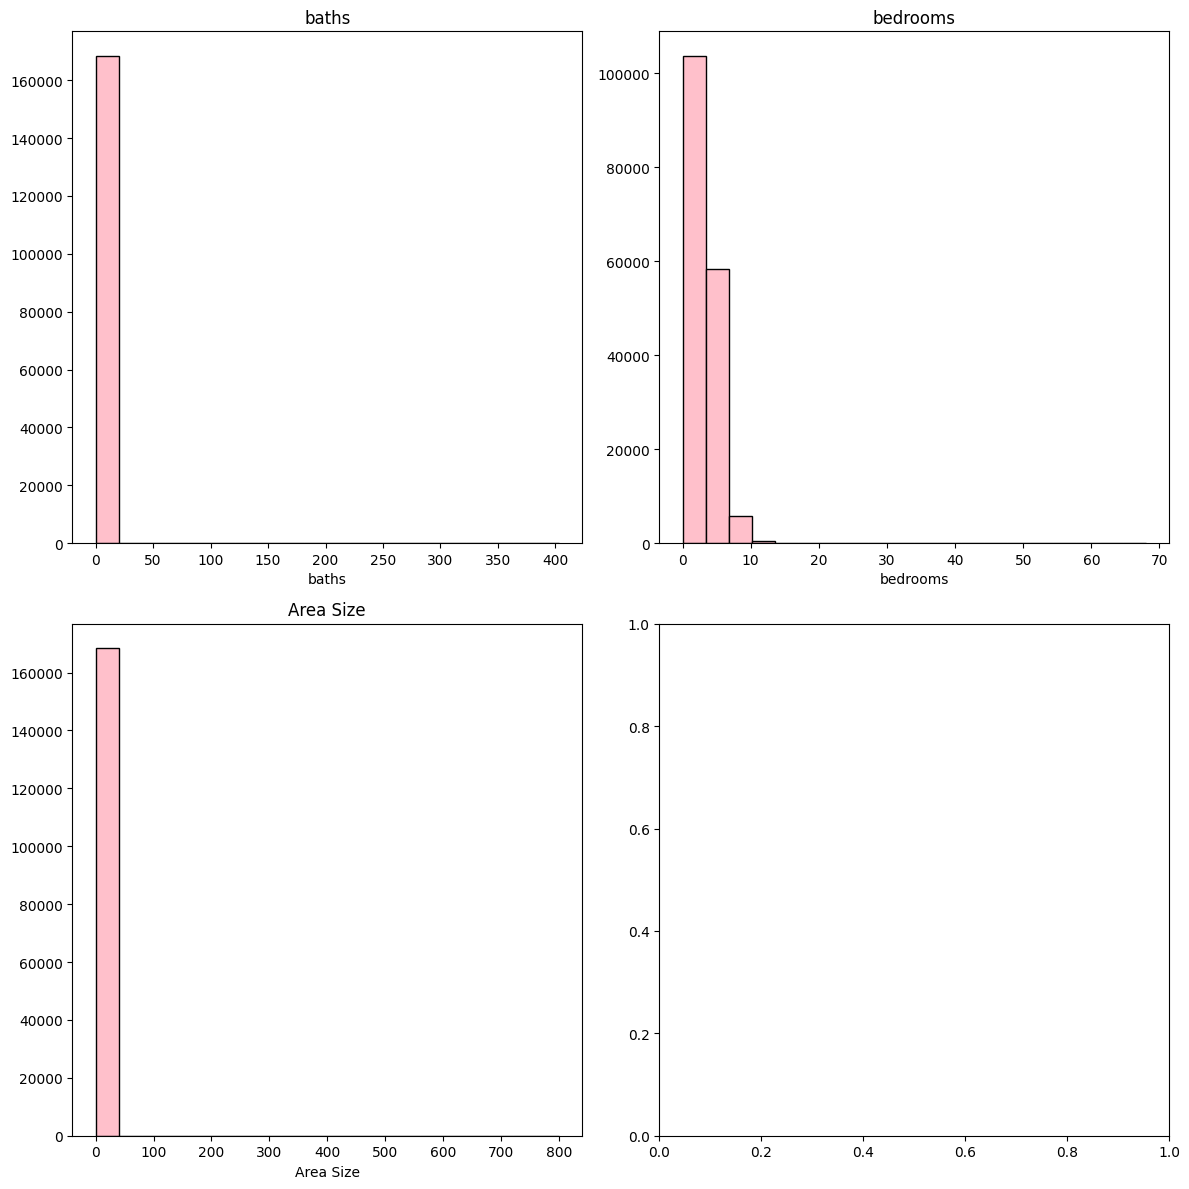

In [13]:
dfeksplorasi = data.copy()

num_cols = dfeksplorasi.select_dtypes(include=["number"])
num_features = len(num_cols.columns)
rows = int(np.ceil(num_features / 2))
# Histogram untuk kolom numerik
fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))
axes = axes.flatten()
for i, col in enumerate(num_cols.columns):
  axes[i].hist(num_cols[col], bins=20, color="pink", edgecolor="black")
  axes[i].set_title(col)
  axes[i].set_xlabel(col)
plt.tight_layout()
plt.show()

**Boxplot Data Numerik**

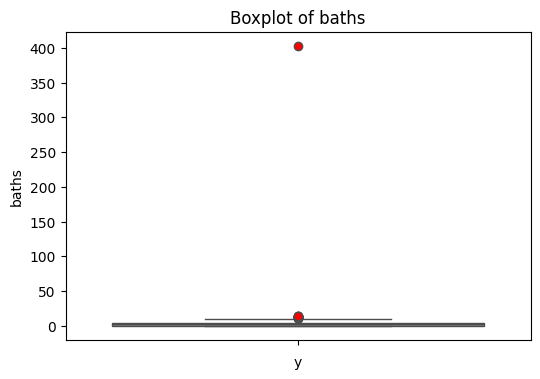

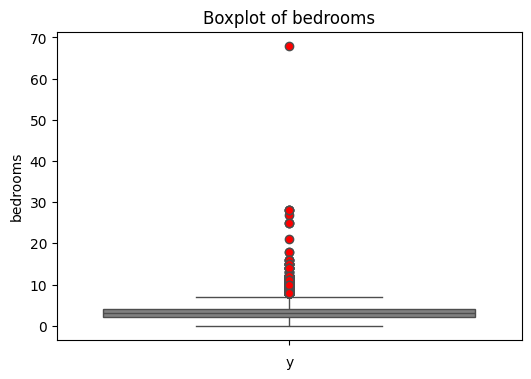

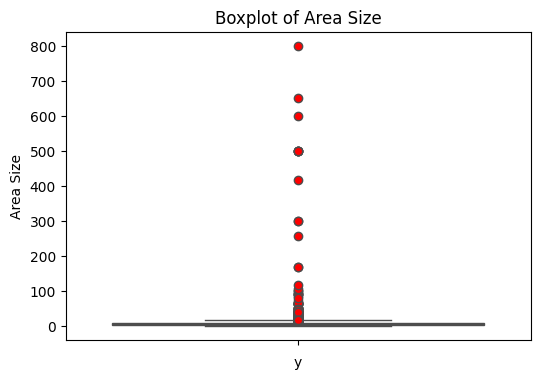

In [14]:
# Melihat sebaran peubah numerik dalam bentuk boxplot
numeric_vars = dfeksplorasi.select_dtypes(include=['number']).columns

# Loop untuk membuat boxplot setiap kolom numerik
for col in numeric_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=data[col], color="grey", flierprops=dict(marker='o', markerfacecolor='red', markersize=6))
    plt.title(f"Boxplot of {col}")
    plt.xlabel("y")
    plt.ylabel(col)
    plt.show()

Berdasarkan histogram dan boxplot yang digunakan dalam eksplorasi sebaran peubah numerik dapat dilihat bahwa terdapat penyebaran yang sangat miring ke kanan *(positively skewed)*. Sebagian besar data terakumulasi pada milai yang rendah, sementara sedikit data menyebar ke nilai yang jauh lebih tinggi. Hal ini dibuktikan pada diagram boxplot yang menunjukkan terdapat banyak outlier dalam data penelitian sehingga batang pada histogram beberapa terisolasi.

**Plot Korelasi**

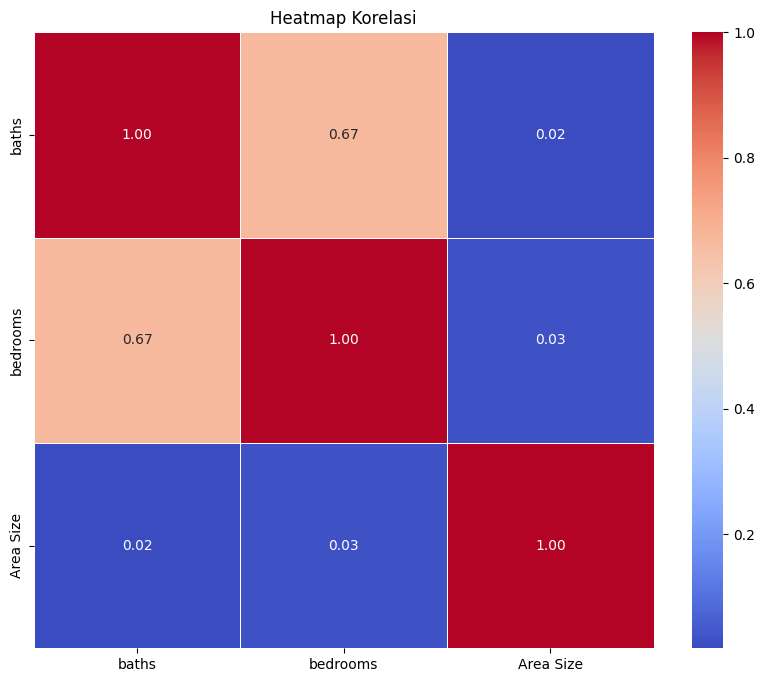

In [15]:
num_cols = dfeksplorasi.select_dtypes(include=[np.number]).columns
correlation_matrix = data[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi")
plt.show()

Korelasi tertinggi pada peubah numerik dimiliki oleh peubah 'bed rooms' dengan peubah 'baths' yaitu sebesar 0.67. Sedangkan, peubah 'Area Size' dengan 'baths' cenderung berkorelasi lemah dengan nilai hanya 0.02

**Diagram Batang**

property_type: 7 unique values
city: 5 unique values
province_name: 3 unique values
purpose: 2 unique values
Area Type: 2 unique values


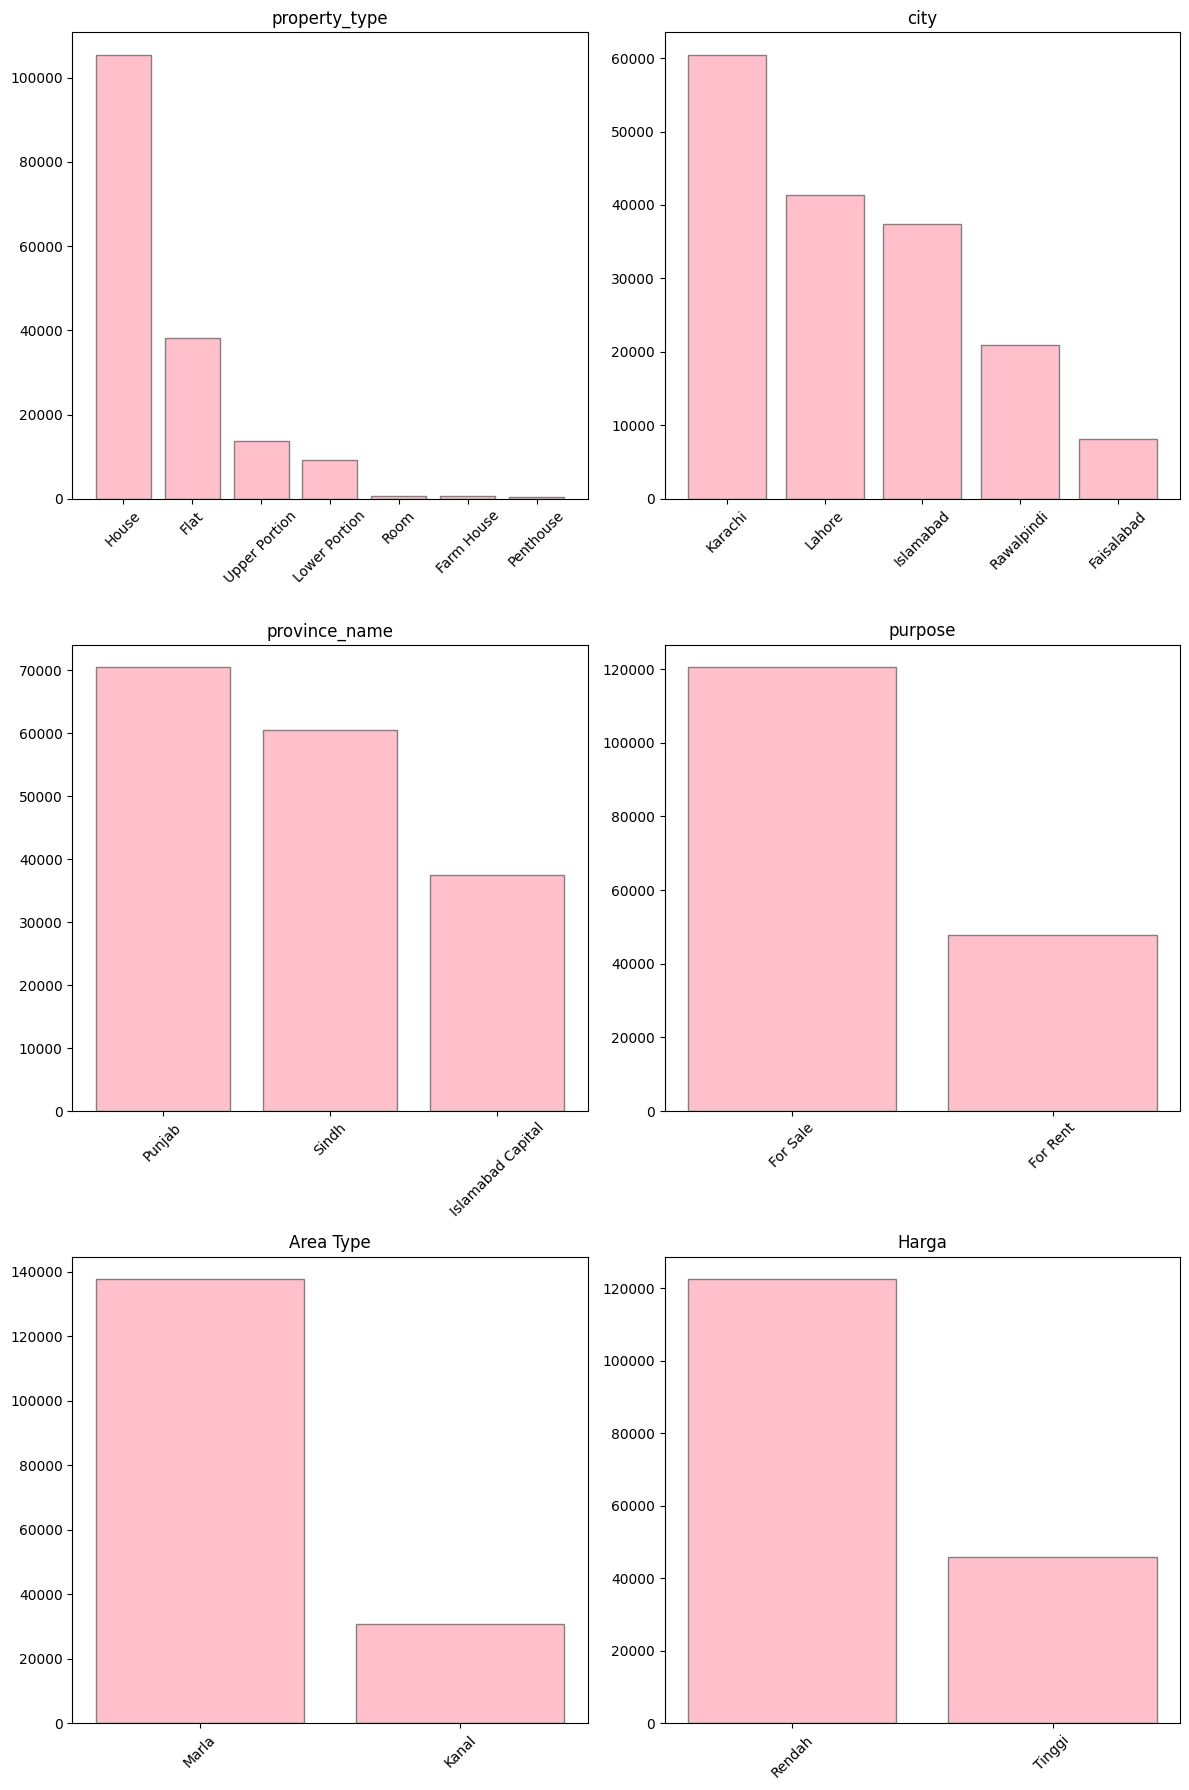

In [16]:

for col in dfeksplorasi.select_dtypes(include=["object"]).columns:
    print(f"{col}: {dfeksplorasi[col].nunique()} unique values")
for col in ["property_type", "city", "province_name", "purpose",
            "Area Type", "Harga"]:
    dfeksplorasi[col] = dfeksplorasi[col].astype("category")
cat_cols = dfeksplorasi.select_dtypes(include=["category"])
num_cats = len(cat_cols.columns)
if num_cats > 0:
    rows = int(np.ceil(num_cats / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))
    axes = axes.flatten()
    for i, col in enumerate(cat_cols.columns):
        counts = cat_cols[col].value_counts()
        axes[i].bar(counts.index, counts.values, color="pink", edgecolor="grey")
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", rotation=45)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kolom kategorikal dalam dataset.")

Berdasarkan diagram batang di atas didapatkan bahwa pada Rumah memiliki frekuensi tertinggi pada peubah Property Type, Kota Karachi menjadi frekuensi tertinggi pada peubah City, Punjab menjadi provinsi dengan frekuensi tertinggi pada peubah Province Name, rumah yang ditujukan untuk Dijual menjadi frekuensi tertinggi pada peubah Purpose, tipe Marla memiliki frekuensi tertinggi dalam peubah Area Type

## **PRE_PROCCESSING DATA**

### **One Hot Encoding**

In [17]:
# Mengonversi kategorik menjadi angka sebelum OHE
for col in data.select_dtypes(include=['object']):
    data[col] = data[col].astype('category').cat.codes

# One-Hot Encoding
for col in data.select_dtypes(include=['object']):
    data[col] = list(to_categorical(data[col]))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168446 entries, 0 to 168445
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   property_type  168446 non-null  int8    
 1   city           168446 non-null  int8    
 2   province_name  168446 non-null  int8    
 3   baths          168446 non-null  int64   
 4   purpose        168446 non-null  int8    
 5   bedrooms       168446 non-null  int64   
 6   Area Type      168446 non-null  int8    
 7   Area Size      168446 non-null  float64 
 8   Harga          168446 non-null  category
dtypes: category(1), float64(1), int64(2), int8(5)
memory usage: 4.8 MB


Pada tahapan ini jika peubah yang bertipe objek dikarenaka bentuk datanya berupa teks atau kategorik akan diubah menjadi tipe data category dan mengonversinya kategori menjadi kode angka, hal ini ditujukan agar data dapat diolah lebih lanjut dikarenakan algoritma ML tida bisa manganalisis data teks secara langsusng

In [18]:
data

,property_type,city,province_name,baths,purpose,bedrooms,Area Type,Area Size,Harga
0,1,1,0,2,1,2,1,4.0,Rendah
1,1,1,0,3,1,3,1,5.6,Rendah
2,2,1,0,6,1,5,1,8.0,Rendah
3,2,1,0,4,1,4,0,2.0,Tinggi
4,2,1,0,3,1,3,1,8.0,Rendah
...,...,...,...,...,...,...,...,...,...
168441,2,2,2,0,1,6,1,9.6,Tinggi
168442,2,2,2,0,1,3,1,8.0,Rendah
168443,2,2,2,0,1,6,1,9.6,Tinggi
168444,2,2,2,0,1,3,1,7.8,Rendah


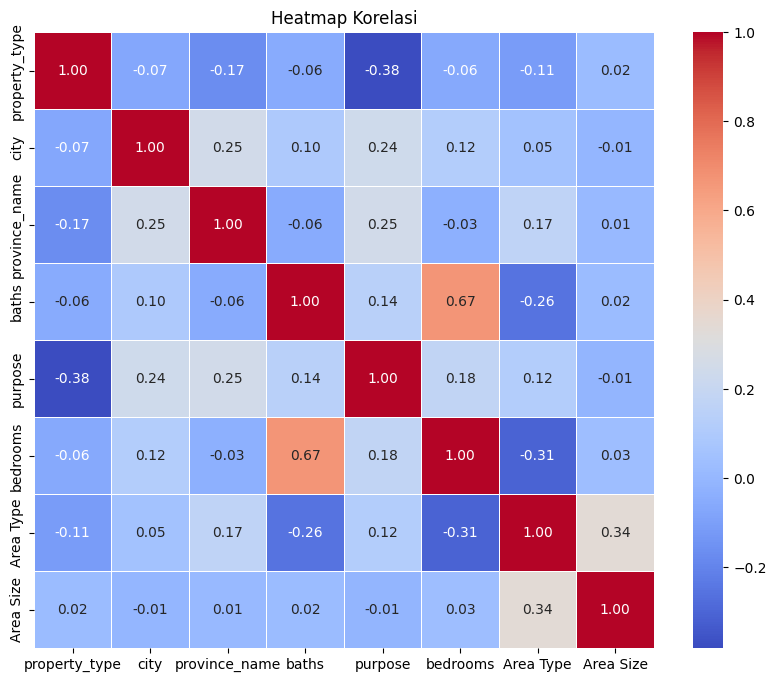

In [53]:
num_cols = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi")
plt.show()

### **SPLITTING DATA**

In [20]:
# Set seed untuk reproduktifitas
np.random.seed(123)


# Membagi data menjadi train dan test (80% train, 20% test)
train, test = train_test_split(data, test_size=0.2, stratify=data['Harga'], random_state=123)

# Pisahkan fitur dan target
train_X = train.drop('Harga', axis=1)
test_X = test.drop('Harga', axis=1)
train_y = train['Harga']
test_y = test['Harga']

# Feature Scaling menggunakan Min-Max Scaler
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

# OHE pada peubah target
train_y = to_categorical(train_y.astype('category').cat.codes)
test_y = to_categorical(test_y.astype('category').cat.codes)

# Output shape dari hasil encoding
print("Shape train_X:", train_X.shape)
print("Shape test_X:", test_X.shape)
print("Shape train_y:", train_y.shape)
print("Shape test_y:", test_y.shape)

Shape train_X: (134756, 8)
Shape test_X: (33690, 8)
Shape train_y: (134756, 2)
Shape test_y: (33690, 2)


Pembagian data dilakukan dengan rasio 8:2 atau 80% digunakan sebagai data latih pembentukan model sedangan 20% data digunakan sebagai data uji sebagai evaluasi model yang terbentuk. Hal ini dikarenakan dimensi data yang cenderung besar sehingga data latih dapat memanfaatkan lebih banyak data untuk mempelajari pola kompleks serta mengurangi risiko overfitting pada data yang berdimensi tinggi.

## **ANN: 1 HIDDEN LAYER**

In [21]:
# Membuat model neural network dengan 1 hidden layer
model = Sequential([
    Dense(256, activation='relu', input_shape=(train_X.shape[1],)),  # Hidden Layer 1
    Dense(train_y.shape[1], activation='softmax')  # Output Layer
])

# Mengkompilasi model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,818 (11.01 KB)

 Trainable params: 2,818 (11.01 KB)

 Non-trainable params: 0 (0.00 B)

Arsitektur model yang terbentuk memiliki tipe model sequential atau berlapis dengan jumlah layer sebanyak 2 yang terdiri atas 1 hidden layer dan 1 ouput layer. Batch size pada hasil keluarnya *none* atau fleksibel karena belum ditentukan. Hiiden layer terdiri atas 256 neuron yang diaktivasi dengan relu yang harus mempelajari 2304 parameter. Sedangkan, pada output layer terdiri atas 2 neuron (untuk klasifikasi 2 kelas) dengan aktivasi softmax, parameter yang dipelajari pada layer ini sebanyak 514. 2818 parameter bisa dipelajari (diboboti) oleh model (*trainable*)

Epoch 1/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8168 - loss: 0.4032 - val_accuracy: 0.8708 - val_loss: 0.2972
Epoch 2/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8675 - loss: 0.2921 - val_accuracy: 0.8823 - val_loss: 0.2654
Epoch 3/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8842 - loss: 0.2655 - val_accuracy: 0.8904 - val_loss: 0.2399
Epoch 4/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9003 - loss: 0.2403 - val_accuracy: 0.9138 - val_loss: 0.2195
Epoch 5/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9067 - loss: 0.2249 - val_accuracy: 0.9112 - val_loss: 0.2126
Epoch 6/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9093 - loss: 0.2184 - val_accuracy: 0.9151 - val_loss: 0.2100
Epoch 7/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9089 - loss: 0.2213 - val_accuracy: 0.9121 - val_loss: 0.2070
Epoch 8/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9099 - loss: 0.2140 - val_accu

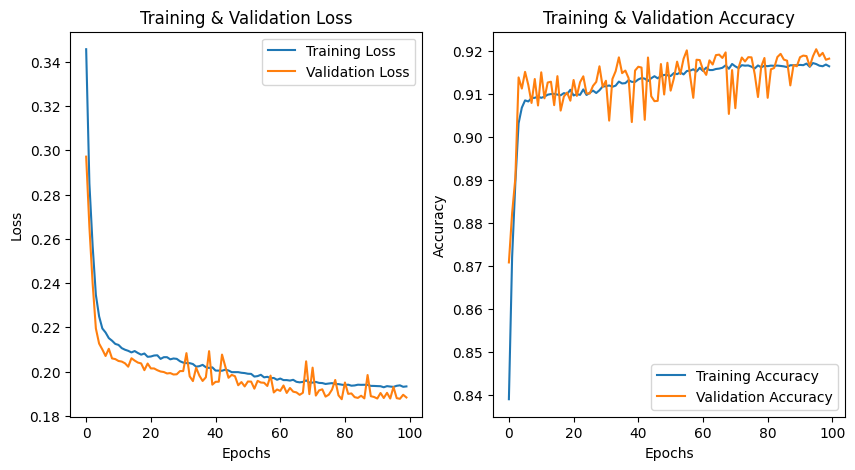

In [22]:
# Melatih model
history = model.fit(
    train_X, train_y,
    shuffle=True,
    epochs=100,
    batch_size=128,
    validation_split=0.2
)

# Menampilkan plot pembelajaran model pada setiap epoch
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()



*   Analisis Grafik Loss



Terjadi penurunan yang konsisten di awal dimana baik train atau pun train loss turun drastis pada iterasi epoch 0-20. Setelah 20 epoch kedua loss cenderung stabil dan hampir sejajar, validation loss sedikit lebih tinggi namaun tetap mirip dengan training loss. Tidak terdapat overfitting yang signifikan

*   Analisis Grafik Accuracy

Akurasi meningkat cepat mendekati 92% pada epoch 0-20. Setelah 20 epoch, akurasi stabil di sekitar 90-82%. Pola training dan validation accuracy serupa sehingga tidak terjadi overfitting

Berdasarkan pembentukan model dengan 100 epoch menghasilkan performansi yang baik dengan loss rendah dan akurasi tinggi, model mampu melakukan generalisasi dengan baik ditunjukkan dengan training dan validation yang hampir sejajar, serta tidak terindikasi adanya overitting dari grafik pembelajaran model.

In [23]:
# Mengevaluasi model menggunakan data uji
scores = model.evaluate(test_X, test_y)

# Menampilkan hasil evaluasi (loss dan accuracy)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9153 - loss: 0.1947
Test Loss: 0.1930
Test Accuracy: 0.9149


Nilai **loss pada data uji** sebesar **0.1930** yang cukup rendah mengindikasikan bahwa model tidak mengalami overfitting yang signifikan dan dapat melakukan generalisasi dengan baik terhadap data baru. Nilai **akurasi pada data uji** sebesar **0.9159** atau model berhasil melakukan generalisasi pada data baru yang belum pernah dipelajari sebelumnya dengan tingkat keakuratan **91.49**

## **ANN 2 HIDDEN LAYER**

In [24]:

# Membuat model neural network dengan 2 hidden layer
model = Sequential([
    Dense(512, activation='relu', input_shape=(train_X.shape[1],)),  # Hidden Layer 1
    Dropout(0.2),
    Dense(128, activation='relu'),  # Hidden Layer 2
    Dropout(0.2),
    Dense(train_y.shape[1], activation='softmax')  # Output Layer
])

# Mengkompilasi model
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Menampilkan ringkasan model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 512)                 │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,530 (275.51 KB)

 Trainable params: 70,530 (275.51 KB)

 Non-trainable params: 0 (0.00 B)

**Hidden Layer 1** (dense 2) memiliki 512 jumlah neuran dengan aktivasi relu yang berperan untuk menangkap pola komplek dalam data. Dropout (0.2) bertfungsu untuk mencegah overfitting dengan menonaktifkan 20% neuron secara acak saat training

**Hidden Layer 2** (dense 3) dengan jumlah neuron 128 menggunakan aktivasi relu. Dropout (0.2) sama seperti sebelumnya berfungsi untuk mencegah overfitting

**Output Layer** (dense 4) memiliki jumlah neuron 2 untuk fungsi klasifikasi biner.

Total terdapat 70,530 parameter yang bisa dipelajari oleh model

In [31]:
# Melatih model
history = model.fit(
    train_X, train_y,
    shuffle=True,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0  # Tidak menampilkan output setiap epoch
)

# Menampilkan ringkasan model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 512)                 │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,592 (826.54 KB)

 Trainable params: 70,530 (275.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,062 (551.03 KB)

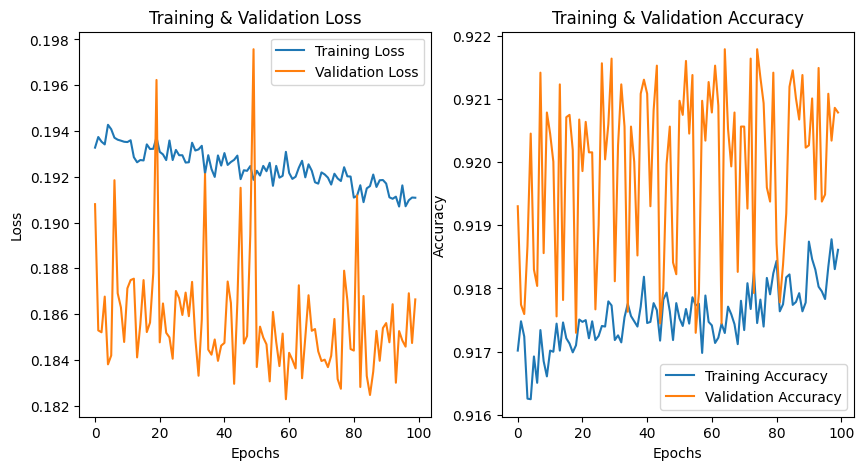

In [32]:
# Menampilkan plot pembelajaran model pada setiap epoch
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [33]:
# Mengevaluasi model menggunakan data uji
scores = model.evaluate(test_X, test_y, verbose=0)  # verbose=0 untuk menyembunyikan output evaluasi

# Menampilkan hasil evaluasi (loss dan accuracy)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

Test Loss: 0.1910
Test Accuracy: 0.9176


ANN dengan 2 Hidden Layer menghasilkan prediksi yang lebih tinggi namun tidak berbeda signifikan. Prediksi yang dihasilkan sebesar 91.76% dengan nilai loss 0.1910 yang menunjukkan bahwa performansi model ANN 2 hidden layer lebip optimal.

In [39]:
# Parameter model
input_dim = train_X.shape[1]  # Jumlah fitur input
output_dim = train_y.shape[1] # Jumlah kelas output

# Daftar optimizer yang akan diuji
optimizers = {
    "SGD": SGD(learning_rate=0.01),
    "Momentum_SGD": SGD(learning_rate=0.01, momentum=0.9),
    "Adam": Adam(learning_rate=0.01),
    "RMSprop": RMSprop(learning_rate=0.01)
}

# Fungsi untuk membuat model dengan optimizer tertentu
def create_model(optimizer):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),  # Hidden Layer 1
        Dense(output_dim, activation="softmax")  # Output Layer
    ])

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    model.summary()  # Menampilkan arsitektur model

    return model

# Fungsi untuk melatih model dan menyimpan histori loss & akurasi
def train_and_evaluate(optimizer_name, optimizer):
    model = create_model(optimizer)

    history = model.fit(
        train_X, train_y,
        shuffle=True,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Simpan hasil training
    results = pd.DataFrame({
        "optimizer": [optimizer_name] * 100,
        "epoch": list(range(1, 101)),
        "loss": history.history["val_loss"],
        "accuracy": history.history["val_accuracy"]
    })

    return {"model": model, "results": results}


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706 (2.76 KB)

 Trainable params: 706 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706 (2.76 KB)

 Trainable params: 706 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706 (2.76 KB)

 Trainable params: 706 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706 (2.76 KB)

 Trainable params: 706 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

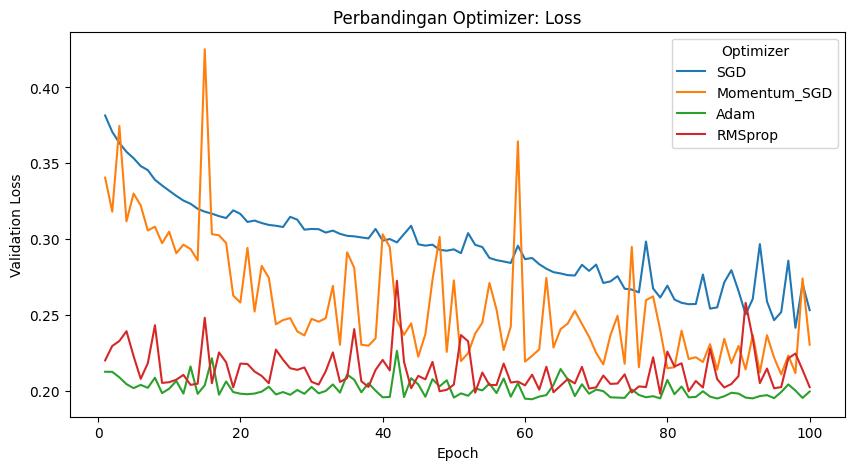

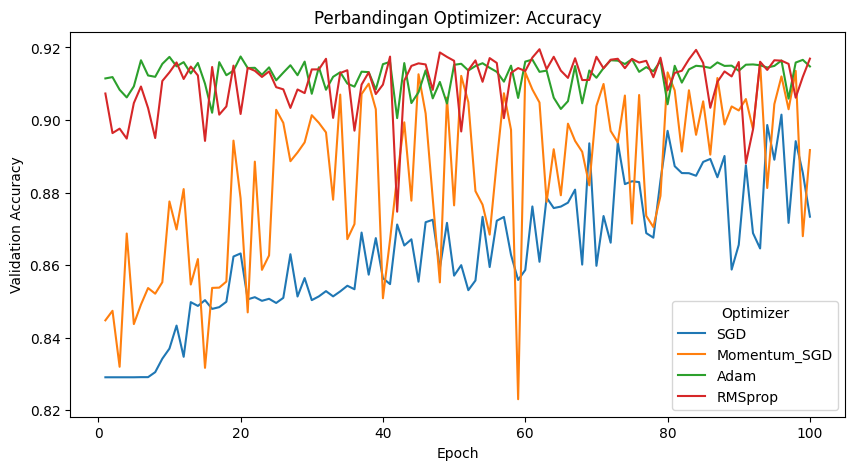

In [40]:
# Jalankan training untuk setiap optimizer
models_results = [train_and_evaluate(name, optimizers[name]) for name in optimizers]

# Menggabungkan hasil training dari semua optimizer
results = pd.concat([res["results"] for res in models_results], ignore_index=True)

# Menyimpan model yang telah dilatih
models = {name: res["model"] for name, res in zip(optimizers.keys(), models_results)}

# Plot perbandingan loss antar optimizer
plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x="epoch", y="loss", hue="optimizer")
plt.title("Perbandingan Optimizer: Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend(title="Optimizer")
plt.show()

# Plot perbandingan akurasi antar optimizer
plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x="epoch", y="accuracy", hue="optimizer")
plt.title("Perbandingan Optimizer: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(title="Optimizer")
plt.show()


Optimizer Adam dan RMSprop memiliki performansi terbaik jika dibandingkan optimizer lainnya dengan nilai loss paling rendah dan akurasi paling tinggi. Pola fluktuatif yang ada relatif rendah dan cukup stabil

In [41]:
# Mengevaluasi setiap model dengan data uji dan menyimpan hasilnya
evaluation_results = {}

for name, model in models.items():
    scores = model.evaluate(test_X, test_y, verbose=0)  # Evaluasi model
    evaluation_results[name] = {"Test Loss": scores[0], "Test Accuracy": scores[1]}

# Menampilkan hasil evaluasi untuk setiap optimizer
for name, result in evaluation_results.items():
    print(f"Optimizer: {name}")
    print(f"Test Loss: {result['Test Loss']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("-" * 30)

Optimizer: SGD
Test Loss: 0.2567
Test Accuracy: 0.8754
------------------------------
Optimizer: Momentum_SGD
Test Loss: 0.2335
Test Accuracy: 0.8905
------------------------------
Optimizer: Adam
Test Loss: 0.2041
Test Accuracy: 0.9118
------------------------------
Optimizer: RMSprop
Test Loss: 0.2052
Test Accuracy: 0.9145
------------------------------


Berdasarkan evaluasi nilai akurasi didapatkan bahwa optimizer RMSprop menghasilkan performansi terbaik dengan nilai akurasi 91.45% dibandingkan optimizer lainnya

In [42]:
# Daftar learning rate yang akan diuji
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# Fungsi untuk membuat model dengan learning rate tertentu
def create_model(learning_rate):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),  # Hidden Layer
        Dense(output_dim, activation="softmax")  # Output Layer
    ])

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model

# Fungsi untuk melatih model dan menyimpan hasil
def train_and_evaluate(lr_name, learning_rate):
    model = create_model(learning_rate)

    history = model.fit(
        train_X, train_y,
        shuffle=True,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Simpan hasil training dan validasi dalam DataFrame
    results = pd.DataFrame({
        "learning_rate": [lr_name] * 100,
        "epoch": list(range(1, 101)),
        "train_loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "train_accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"]
    })

    return {"model": model, "history": results}


In [43]:
# Menyimpan hasil training dan model untuk setiap learning rate
results_list = {}
models = {}

for lr in learning_rates:
    lr_name = f"lr_{lr}"  # Contoh nama model: lr_0.001
    train_result = train_and_evaluate(lr_name, lr)

    models[lr_name] = train_result["model"]  # Simpan model
    results_list[lr_name] = train_result["history"]  # Simpan hasil training

# Gabungkan semua hasil training ke dalam satu dataframe
results = pd.concat(results_list.values(), ignore_index=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


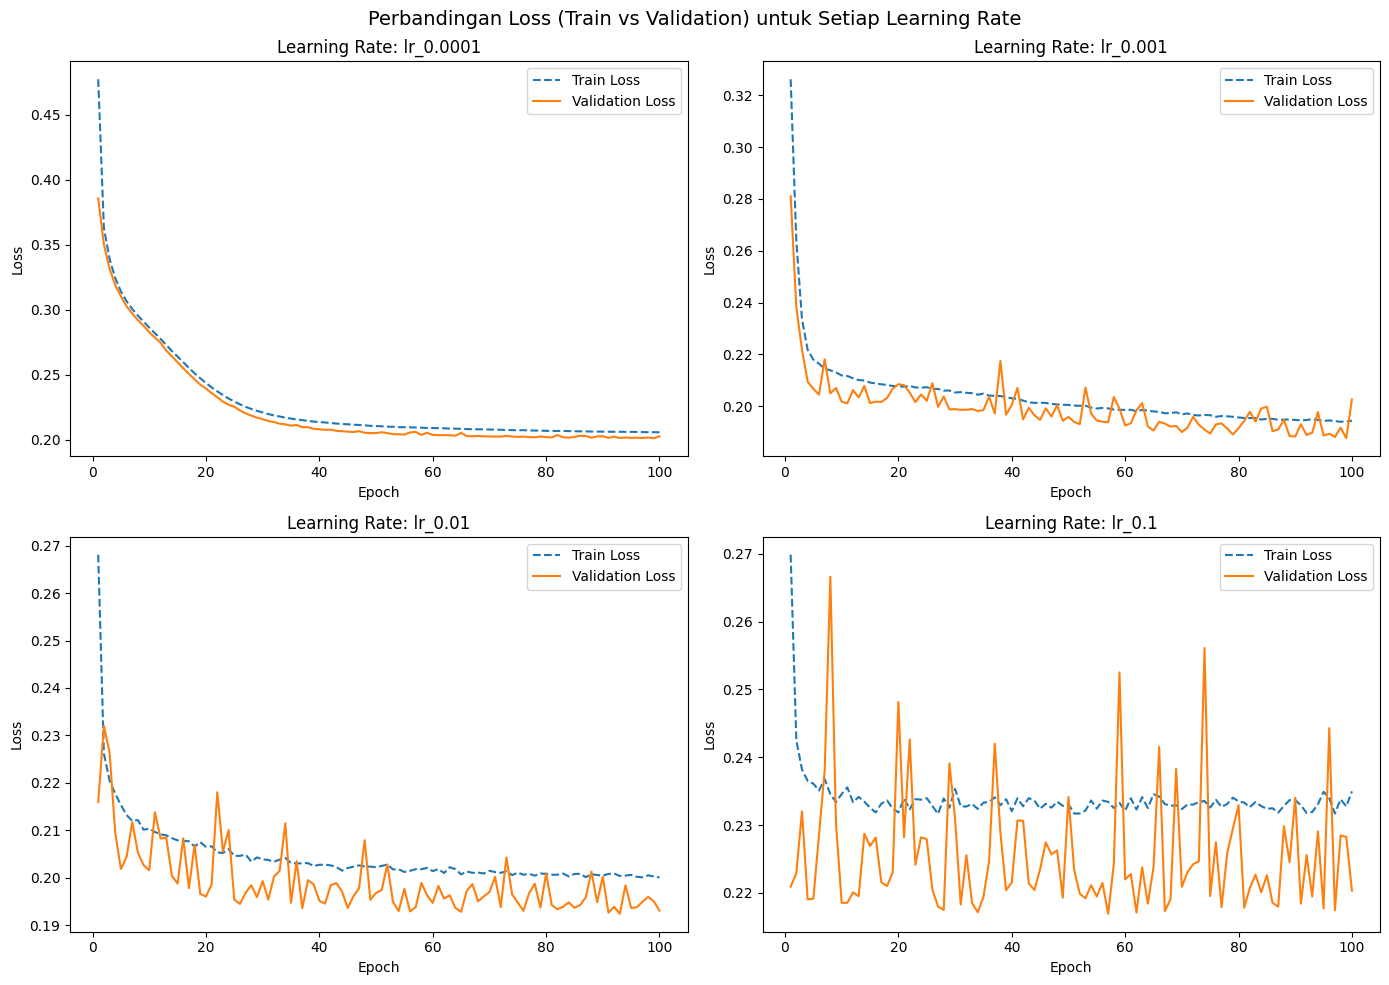

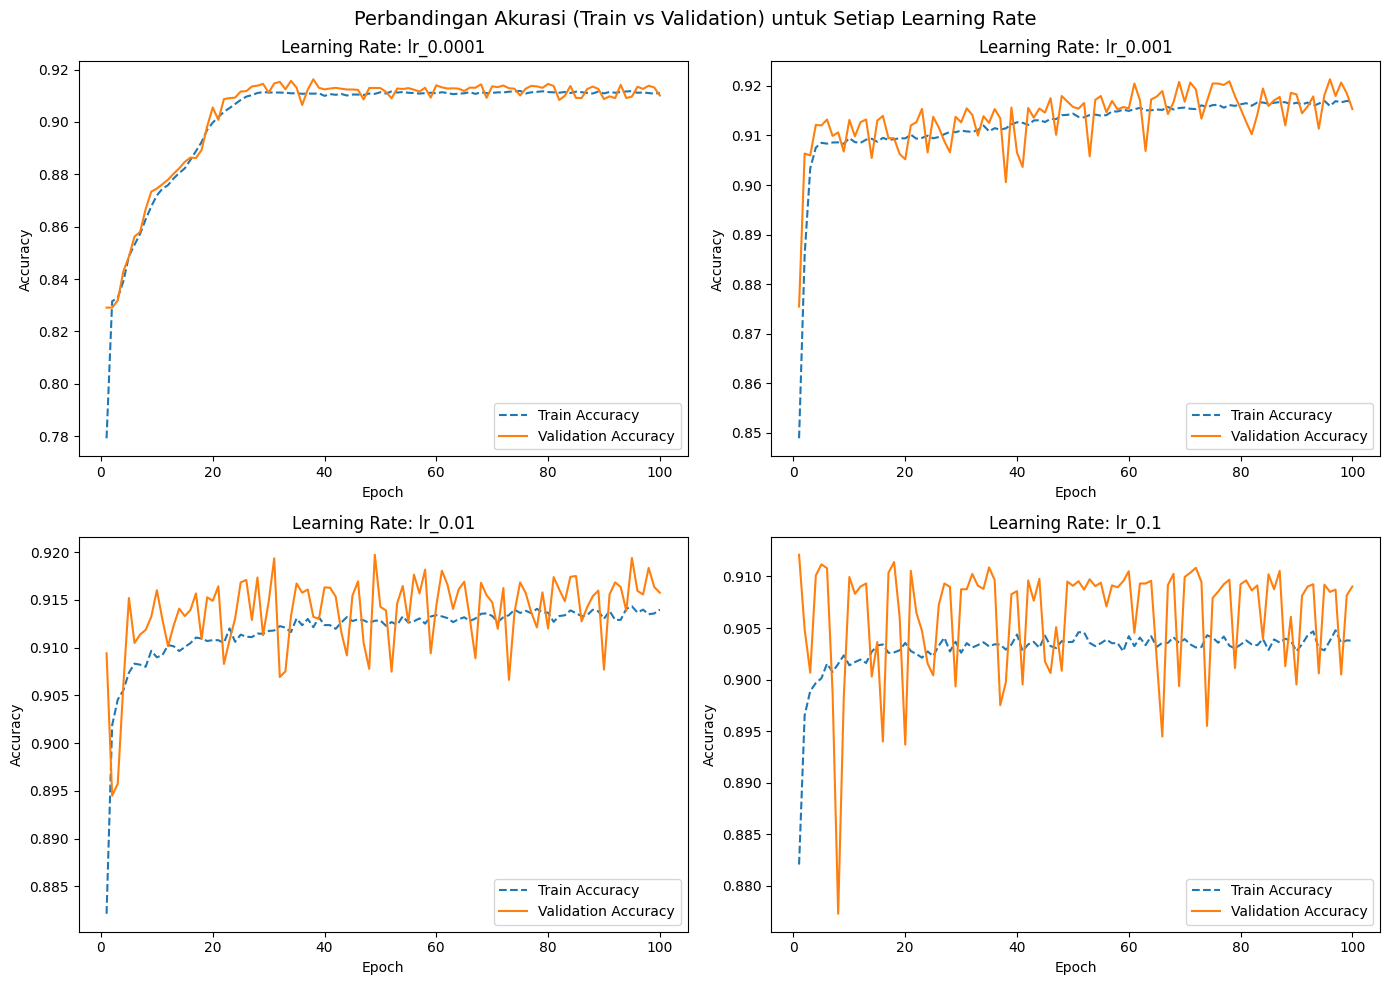

In [44]:
# Dapatkan daftar unique learning rate
unique_lrs = results["learning_rate"].unique()

# Buat subplot dengan 2 baris, 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten agar lebih mudah diakses dengan loop

# Loop untuk membuat grafik Loss per learning rate
for i, lr in enumerate(unique_lrs):
    subset = results[results["learning_rate"] == lr]

    sns.lineplot(ax=axes[i], data=subset, x="epoch", y="train_loss", label="Train Loss", linestyle="dashed")
    sns.lineplot(ax=axes[i], data=subset, x="epoch", y="val_loss", label="Validation Loss")

    axes[i].set_title(f"Learning Rate: {lr}")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.suptitle("Perbandingan Loss (Train vs Validation) untuk Setiap Learning Rate", fontsize=14)
plt.tight_layout()
plt.show()

# Buat subplot dengan 2 baris, 2 kolom untuk Accuracy
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop untuk membuat grafik Accuracy per learning rate
for i, lr in enumerate(unique_lrs):
    subset = results[results["learning_rate"] == lr]

    sns.lineplot(ax=axes[i], data=subset, x="epoch", y="train_accuracy", label="Train Accuracy", linestyle="dashed")
    sns.lineplot(ax=axes[i], data=subset, x="epoch", y="val_accuracy", label="Validation Accuracy")

    axes[i].set_title(f"Learning Rate: {lr}")
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Accuracy")
    axes[i].legend()

plt.suptitle("Perbandingan Akurasi (Train vs Validation) untuk Setiap Learning Rate", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Evaluasi setiap model pada data uji
for lr_name, model in models.items():
    scores = model.evaluate(test_X, test_y, verbose=0)  # Evaluasi model
    print(f"{lr_name}:")
    print(f"  - Test Loss: {scores[0]:.4f}")
    print(f"  - Test Accuracy: {scores[1]:.4f}")
    print("-" * 40)


***Menghasilkan Prediksi***

In [46]:
# Melakukan prediksi pada data uji
prediksi = models["lr_0.01"].predict(test_X)
print(prediksi[:5])  # Menampilkan 5 prediksi pertama

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[0.9580457  0.04195431]
 [0.97930735 0.02069279]
 [0.9776656  0.0223345 ]
 [0.90014714 0.09985285]
 [0.20145841 0.7985416 ]]


In [47]:
# Konversi probabilitas ke label kelas tertinggi (argmax)
label_pred = np.argmax(prediksi, axis=1)

# Label sebenarnya dari dataset
label_true = test["Harga"].map({"Rendah": 0, "Tinggi": 1}).astype(int)


In [48]:
# Menampilkan confusion matrix
cm = confusion_matrix(label_true, label_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[23197  1322]
 [ 1550  7621]]


In [49]:
# Menampilkan classification report (precision, recall, f1-score)
print("\nClassification Report:\n", classification_report(label_true, label_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94     24519
           1       0.85      0.83      0.84      9171

    accuracy                           0.91     33690
   macro avg       0.89      0.89      0.89     33690
weighted avg       0.91      0.91      0.91     33690



In [50]:
# Mengevaluasi model menggunakan data uji
scores = models["lr_0.01"].evaluate(test_X, test_y, verbose=0)
print(f"\nTest Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")


Test Loss: 0.1977
Test Accuracy: 0.9148


In [51]:
# Mengevaluasi model menggunakan data uji
scores = models["lr_0.01"].evaluate(test_X, test_y, verbose=0)
print(f"\nTest Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")


Test Loss: 0.1977
Test Accuracy: 0.9148


**Menyimpan dan Memuat Model**

In [52]:
# Menyimpan model dalam format HDF5
models["lr_0.01"].save("model_nn_sgd.h5")

# Memuat model dari file HDF5
new_model = load_model("model_nn_sgd.h5")

# Kompilasi ulang sebelum evaluasi
new_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Menampilkan arsitektur model yang dimuat
new_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706 (2.76 KB)

 Trainable params: 706 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

# **Kesimpulan**

Berdasarkan hasil analisisa klasifikasi ANN yang telah dilakukan didapatkan bahwa akurasi tertinggi yang bisa dihasilkan berada di angka 91.76% yang dihasilkan dari proses ANN dengan 2 hidden layer

# **Perbandingan dengan Decision Tree Classifier**

Hasil akurasi model klasifikasi dengan ANN ataupun metode CART tidak memiliki perbedaan yang jauh signifikan. Namun, model dengan **CART Classifier** berhasil unggul dalam nilai evaluasi akurasi yaitu di angka** 92%**. Nilai ini tidak berbeda jauh dengan akurai **Classification ACC** yang menghasilkan angka **91.76**.

Kedua model tetap layak dan memiliki tingkat akurasi tinggi yang hanya berbeda sedikit. Model CART menyajikan kesederhanaan dalam intepretai yang memudahkan untuk memahami hasil outputnya. ANN cocok untuk mendapatkan akurasi tinggi dari pola data yang lebih kompleks dan interpretasi bukan menjadi prioritas utama dari pengklasifikasian.